1. Import package and data loading

In [1]:
# import package
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchcrf import CRF
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from collections import Counter

In [2]:
# load data
data = pd.read_csv('/Users/zhangzhengyang/Downloads/Ebay Data Challenge/coding here/eBay_ML_Challenge_2025/Listing_Titles.tsv', keep_default_na=False, na_values=None,sep='\t')
data_train = pd.read_csv('/Users/zhangzhengyang/Downloads/Ebay Data Challenge/coding here/eBay_ML_Challenge_2025/Tagged_Titles_Train.tsv', keep_default_na=False, na_values=None,sep='\t')
data_train.head(20)
data_train["Tag"] = data_train["Tag"].replace("", pd.NA).ffill()
print(data.shape)
data_train.head(20)

(2000000, 3)


,Record Number,Category,Title,Token,Tag
0,1,2,MINI 1.6 W10B16A W11B16A R50 Steuerkettensatz ...,MINI,Kompatible_Fahrzeug_Marke
1,1,2,MINI 1.6 W10B16A W11B16A R50 Steuerkettensatz ...,1.6,Kompatibles_Fahrzeug_Modell
2,1,2,MINI 1.6 W10B16A W11B16A R50 Steuerkettensatz ...,W10B16A,Herstellernummer
3,1,2,MINI 1.6 W10B16A W11B16A R50 Steuerkettensatz ...,W11B16A,Herstellernummer
4,1,2,MINI 1.6 W10B16A W11B16A R50 Steuerkettensatz ...,R50,Herstellernummer
5,1,2,MINI 1.6 W10B16A W11B16A R50 Steuerkettensatz ...,Steuerkettensatz,Produktart
6,1,2,MINI 1.6 W10B16A W11B16A R50 Steuerkettensatz ...,11311485400,Herstellernummer
7,1,2,MINI 1.6 W10B16A W11B16A R50 Steuerkettensatz ...,Steuerkette,Im_Lieferumfang_Enthalten
8,1,2,MINI 1.6 W10B16A W11B16A R50 Steuerkettensatz ...,FEBI,Hersteller
9,1,2,MINI 1.6 W10B16A W11B16A R50 Steuerkettensatz ...,31803,Herstellernummer


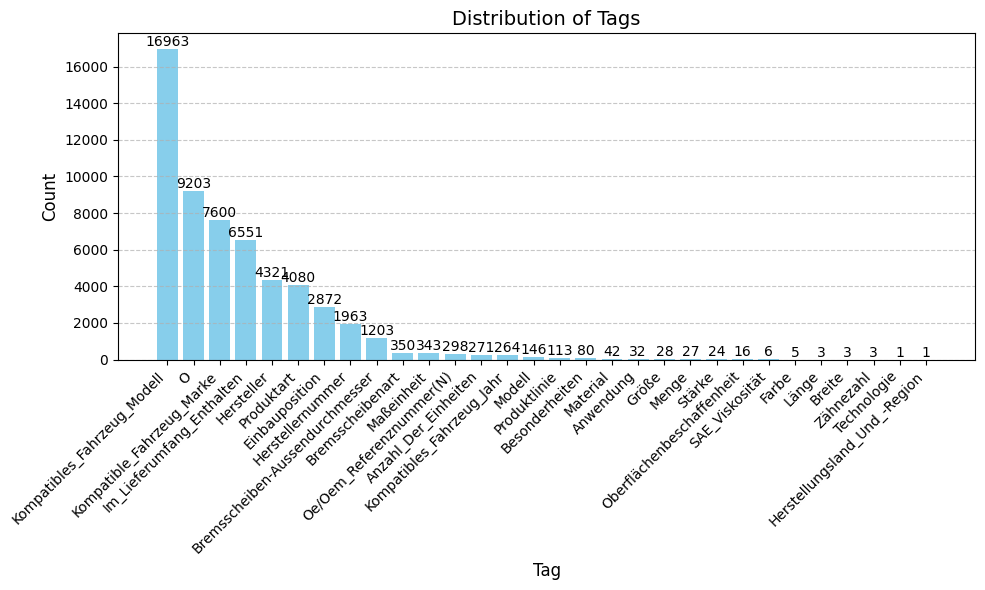

In [3]:
# Count the frequency of each tag
tag_counts = data_train['Tag'].value_counts()

# Create the bar plot (histogram-like)
plt.figure(figsize=(10, 6))
bars = plt.bar(tag_counts.index, tag_counts.values, color='skyblue')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Customize the plot
plt.title('Distribution of Tags', fontsize=14)
plt.xlabel('Tag', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Show the plot
plt.tight_layout()  # Prevent label cutoff
plt.show()

In [4]:
# Data -> sentences + categories
# data_train columns: ["Record Number","Token","Tag","Category"]
sentences = []
categories = []
for rec_id, g in data_train.groupby("Record Number"):
    s = list(zip(g["Token"].tolist(), g["Tag"].tolist()))
    c = int(g["Category"].iloc[0])  # 1 or 2
    sentences.append(s)
    categories.append(c)

# ---------- Vocabularies ----------
words = list(set(data_train["Token"].values)) # all unique tokens in the training dataset.
tags  = list(set(data_train["Tag"].values))

word2idx = {w: i+2 for i, w in enumerate(words)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1

tag2idx = {t: i+1 for i, t in enumerate(tags) if t != "PAD"}  # ensure PAD not duplicated
tag2idx["PAD"] = 0
idx2tag = {i: t for t, i in tag2idx.items()}

# Category -> index (embed-friendly)
cat2idx = {1: 0, 2: 1}

# Max length
MAXLEN = max(len(s) for s in sentences)

In [5]:

# ---------- Dataset ----------
class NERDataset(Dataset):
    def __init__(self, sentences, categories, word2idx, tag2idx, cat2idx, maxlen):
        self.sentences = sentences
        self.categories = categories
        self.word2idx = word2idx
        self.tag2idx  = tag2idx
        self.cat2idx  = cat2idx
        self.maxlen   = maxlen

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        s = self.sentences[idx]
        c = self.categories[idx]
        token_ids = [self.word2idx.get(w, self.word2idx["UNK"]) for w, _ in s] # If w is not in the dictionary, return the index for "UNK".
        tag_ids   = [self.tag2idx[t] for _, t in s]
        pad_len = self.maxlen - len(token_ids)
        if pad_len > 0:
            token_ids += [self.word2idx["PAD"]] * pad_len
            tag_ids   += [self.tag2idx["PAD"]] * pad_len
        else:
            token_ids = token_ids[:self.maxlen]
            tag_ids   = tag_ids[:self.maxlen]
        return (
            torch.tensor(token_ids, dtype=torch.long),
            torch.tensor(tag_ids,   dtype=torch.long),
            torch.tensor(self.cat2idx[c], dtype=torch.long)
        )

In [18]:
# ---------- Splits & loaders ----------
train_sents, val_sents, train_cats, val_cats = train_test_split(
    sentences, categories, test_size=0.1, random_state=1
)

train_dataset = NERDataset(train_sents, train_cats, word2idx, tag2idx, cat2idx, MAXLEN)
val_dataset   = NERDataset(val_sents,   val_cats,   word2idx, tag2idx, cat2idx, MAXLEN)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_tags = len(tag2idx)
vocab_size = len(word2idx)
num_cats = len(cat2idx)
PAD_TAG_IDX = tag2idx["PAD"]

In [7]:
# BiLSTM (no CRF)
class BiLSTMWithCategory(nn.Module):
    def __init__(self, vocab_size, tagset_size, catset_size, embedding_dim=128, cat_dim=10, hidden_dim=256):
        super().__init__()
        self.word_emb = nn.Embedding(vocab_size, embedding_dim, padding_idx=0) # embeddings for PAD tokens are always zeroed out, so the model ignores them.
        self.cat_emb  = nn.Embedding(catset_size, cat_dim)
        self.lstm = nn.LSTM(embedding_dim + cat_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x_tokens, x_cats):
        # x_tokens: (B, L), x_cats: (B,)
        w = self.word_emb(x_tokens)                    # (B, L, E)
        c = self.cat_emb(x_cats).unsqueeze(1)          # (B, 1, C)
        c = c.expand(-1, x_tokens.size(1), -1)         # (B, L, C)
        z = torch.cat([w, c], dim=-1)                  # (B, L, E+C)
        lstm_out, _ = self.lstm(z)                     # (B, L, H)
        logits = self.fc(lstm_out)                     # (B, L, T)
        return logits

In [8]:
# BiLSTM + CRF
class BiLSTMCRFWithCategory(nn.Module):
    def __init__(self, vocab_size, tagset_size, catset_size, embedding_dim=128, cat_dim=10, hidden_dim=256):
        super().__init__()
        self.word_emb = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.cat_emb  = nn.Embedding(catset_size, cat_dim)
        self.lstm = nn.LSTM(embedding_dim + cat_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def emissions(self, x_tokens, x_cats):
        w = self.word_emb(x_tokens)                    # (B, L, E)
        c = self.cat_emb(x_cats).unsqueeze(1)          # (B, 1, C)
        c = c.expand(-1, x_tokens.size(1), -1)         # (B, L, C)
        z = torch.cat([w, c], dim=-1)                  # (B, L, E+C)
        lstm_out, _ = self.lstm(z)                     # (B, L, H)
        return self.fc(lstm_out)                       # (B, L, T)

    def forward(self, x_tokens, x_cats, tags=None, mask=None, emission_only=False):
        em = self.emissions(x_tokens, x_cats)
        if emission_only:
            return em
        if tags is not None:
            # Negative log-likelihood (to minimize)
            return -self.crf(em, tags, mask=mask, reduction="mean")
        else:
            return self.crf.decode(em, mask=mask)      # list of sequences

In [9]:
# Loss
# Focal Loss
class FocalLoss(nn.Module):
    """
    Focal loss wrapper around cross-entropy logits.
    inputs: (N, C) logits, targets: (N,)
    """
    def __init__(self, weight=None, gamma=2.0, ignore_index=-100):
        super().__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.ce = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index, reduction='none')

    def forward(self, inputs, targets):
        ce = self.ce(inputs, targets)                   # (N,)
        # p = exp(-CE)
        p = torch.exp(-ce)
        loss = (1 - p) ** self.gamma * ce
        # mask ignored
        if self.ignore_index >= 0:
            mask = (targets != self.ignore_index).float()
            loss = loss * mask
            denom = mask.sum().clamp_min(1)
            return loss.sum() / denom
        else:
            return loss.mean()

# Compute class weights
def compute_class_weights(train_dataset, tag2idx, exclude_idx):
    # count real tags (exclude PAD)
    cnt = Counter()
    for _, tags, _ in train_dataset:
        for t in tags.tolist():
            if t != exclude_idx:
                cnt[t] += 1
    # inverse frequency
    weights = []
    for i in range(len(tag2idx)):
        if i == exclude_idx:
            weights.append(0.0)  # PAD gets weight 0
        else:
            weights.append(1.0 / max(cnt[i], 1))
    w = torch.tensor(weights, dtype=torch.float)
    # normalize: average weight ~ 1.0 (optional)
    w = w * (len(w) / (w.sum().clamp_min(1e-8)))
    return w


In [22]:
def make_mask(tags, pad_idx):
    # tags: (B, L) -> mask: (B, L) True where not PAD
    return tags.ne(pad_idx)

def evaluate_logits(model, data_loader, device, tag2idx):
    """For non-CRF models that output logits."""
    model.eval()
    all_pred, all_true = [], []
    with torch.no_grad():
        for x_tokens, y_tags, x_cats in data_loader:
            x_tokens, y_tags, x_cats = x_tokens.to(device), y_tags.to(device), x_cats.to(device)
            logits = model(x_tokens, x_cats)                 # (B, L, T)
            preds = torch.argmax(logits, dim=-1)            # (B, L)
            mask = make_mask(y_tags, PAD_TAG_IDX)
            all_pred.extend(preds[mask].cpu().numpy().tolist())
            all_true.extend(y_tags[mask].cpu().numpy().tolist())
    labels = [i for i in range(len(idx2tag)) if i != tag2idx["PAD"]]
    target_names = [idx2tag[i] for i in labels]

    print(classification_report(all_true, all_pred, labels=labels, target_names=target_names, zero_division=0))

def evaluate_crf(model, data_loader, device, tag2idx):
    """For CRF models. Uses Viterbi-decoded sequences."""
    model.eval()
    all_pred, all_true = [], []
    with torch.no_grad():
        for x_tokens, y_tags, x_cats in data_loader:
            x_tokens, y_tags, x_cats = x_tokens.to(device), y_tags.to(device), x_cats.to(device)
            mask = make_mask(y_tags, PAD_TAG_IDX)
            pred_seqs = model(x_tokens, x_cats, tags=None, mask=mask)  # list of lists
            # flatten predictions and gold with mask
            for ps, yt, m in zip(pred_seqs, y_tags, mask):
                for pi, ti, mi in zip(ps, yt.tolist(), m.tolist()):
                    if mi:
                        all_pred.append(pi)
                        all_true.append(ti)
    labels = [i for i in range(len(idx2tag)) if i != tag2idx["PAD"]]
    target_names = [idx2tag[i] for i in labels]

    print(classification_report(all_true, all_pred, labels=labels, target_names=target_names, zero_division=0))

def flatten_for_token_loss(logits, tags, mask):
    """
    logits: (B,L,T), tags: (B,L), mask: (B,L)
    returns logits2d: (N,T), tags1d: (N,)
    Only keep positions where mask==True
    """
    B, L, T = logits.shape
    logits = logits.view(B*L, T)
    tags   = tags.view(B*L)
    mask   = mask.view(B*L)
    keep   = mask.nonzero(as_tuple=False).squeeze(1)
    return logits[keep], tags[keep]



In [11]:
def train_bilstm(epochs=5, lr=1e-3):
    model = BiLSTMWithCategory(vocab_size, num_tags, num_cats).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_TAG_IDX)
    optim_ = optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs+1):
        model.train()
        total = 0.0
        for x_tokens, y_tags, x_cats in train_loader:
            x_tokens, y_tags, x_cats = x_tokens.to(device), y_tags.to(device), x_cats.to(device)
            optim_.zero_grad()
            logits = model(x_tokens, x_cats)  # (B,L,T)
            loss = criterion(logits.view(-1, num_tags), y_tags.view(-1))
            loss.backward()
            optim_.step()
            total += loss.item()
        print(f"[BiLSTM] Epoch {ep} | Loss: {total/len(train_loader):.4f}")
        evaluate_logits(model, val_loader, device, tag2idx)
    return model

In [12]:
def train_bilstm_focal(epochs=5, lr=1e-3, gamma=2.0):
    model = BiLSTMWithCategory(vocab_size, num_tags, num_cats).to(device)
    # Optional class weights with focal; can pass None or computed weights
    weights = compute_class_weights(train_dataset, tag2idx, PAD_TAG_IDX).to(device)
    criterion = FocalLoss(weight=weights, gamma=gamma, ignore_index=PAD_TAG_IDX)
    optim_ = optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs+1):
        model.train()
        total = 0.0
        for x_tokens, y_tags, x_cats in train_loader:
            x_tokens, y_tags, x_cats = x_tokens.to(device), y_tags.to(device), x_cats.to(device)
            optim_.zero_grad()
            logits = model(x_tokens, x_cats)  # (B,L,T)
            loss = criterion(logits.view(-1, num_tags), y_tags.view(-1))
            loss.backward()
            optim_.step()
            total += loss.item()
        print(f"[BiLSTM+Focal] Epoch {ep} | Loss: {total/len(train_loader):.4f}")
        evaluate_logits(model, val_loader, device, tag2idx)
    return model

In [13]:
def train_bilstm_weighted_ce(epochs=5, lr=1e-3):
    model = BiLSTMWithCategory(vocab_size, num_tags, num_cats).to(device)
    weights = compute_class_weights(train_dataset, tag2idx, PAD_TAG_IDX).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=PAD_TAG_IDX)
    optim_ = optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs+1):
        model.train()
        total = 0.0
        for x_tokens, y_tags, x_cats in train_loader:
            x_tokens, y_tags, x_cats = x_tokens.to(device), y_tags.to(device), x_cats.to(device)
            optim_.zero_grad()
            logits = model(x_tokens, x_cats)
            loss = criterion(logits.view(-1, num_tags), y_tags.view(-1))
            loss.backward()
            optim_.step()
            total += loss.item()
        print(f"[BiLSTM+WeightedCE] Epoch {ep} | Loss: {total/len(train_loader):.4f}")
        evaluate_logits(model, val_loader, device, tag2idx)
    return model

In [14]:
def train_bilstm_crf(epochs=5, lr=1e-3):
    model = BiLSTMCRFWithCategory(vocab_size, num_tags, num_cats).to(device)
    optim_ = optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs+1):
        model.train()
        total = 0.0
        for x_tokens, y_tags, x_cats in train_loader:
            x_tokens, y_tags, x_cats = x_tokens.to(device), y_tags.to(device), x_cats.to(device)
            mask = make_mask(y_tags, PAD_TAG_IDX)
            optim_.zero_grad()
            nll = model(x_tokens, x_cats, tags=y_tags, mask=mask)  # already NEGATIVE log-likelihood
            nll.backward()
            optim_.step()
            total += nll.item()
        print(f"[BiLSTM+CRF] Epoch {ep} | NLL: {total/len(train_loader):.4f}")
        evaluate_crf(model, val_loader, device, tag2idx)
    return model

In [15]:
def train_bilstm_crf_focal(epochs=5, lr=1e-3, gamma=2.0, aux_weight=0.5):
    model = BiLSTMCRFWithCategory(vocab_size, num_tags, num_cats).to(device)
    weights = compute_class_weights(train_dataset, tag2idx, PAD_TAG_IDX).to(device)
    focal = FocalLoss(weight=weights, gamma=gamma, ignore_index=PAD_TAG_IDX)
    optim_ = optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs+1):
        model.train()
        total = 0.0
        for x_tokens, y_tags, x_cats in train_loader:
            x_tokens, y_tags, x_cats = x_tokens.to(device), y_tags.to(device), x_cats.to(device)
            mask = make_mask(y_tags, PAD_TAG_IDX)
            optim_.zero_grad()

            # CRF NLL
            nll = model(x_tokens, x_cats, tags=y_tags, mask=mask)

            # Auxiliary focal on emissions
            em = model.emissions(x_tokens, x_cats)                    # (B,L,T)
            em_flat, y_flat = flatten_for_token_loss(em, y_tags, mask)
            aux = focal(em_flat, y_flat)

            loss = nll + aux_weight * aux
            loss.backward()
            optim_.step()
            total += loss.item()
        print(f"[BiLSTM+CRF+Focal] Epoch {ep} | Loss: {total/len(train_loader):.4f}")
        evaluate_crf(model, val_loader, device, tag2idx)
    return model


In [16]:
def train_bilstm_crf_weighted_ce(epochs=5, lr=1e-3, aux_weight=0.5):
    model = BiLSTMCRFWithCategory(vocab_size, num_tags, num_cats).to(device)
    weights = compute_class_weights(train_dataset, tag2idx, PAD_TAG_IDX).to(device)
    ce = nn.CrossEntropyLoss(weight=weights, ignore_index=PAD_TAG_IDX)
    optim_ = optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs+1):
        model.train()
        total = 0.0
        for x_tokens, y_tags, x_cats in train_loader:
            x_tokens, y_tags, x_cats = x_tokens.to(device), y_tags.to(device), x_cats.to(device)
            mask = make_mask(y_tags, PAD_TAG_IDX)
            optim_.zero_grad()

            # CRF NLL
            nll = model(x_tokens, x_cats, tags=y_tags, mask=mask)

            # Auxiliary weighted CE on emissions
            em = model.emissions(x_tokens, x_cats)                    # (B,L,T)
            em_flat, y_flat = flatten_for_token_loss(em, y_tags, mask)
            aux = ce(em_flat, y_flat)

            loss = nll + aux_weight * aux
            loss.backward()
            optim_.step()
            total += loss.item()
        print(f"[BiLSTM+CRF+WeightedCE] Epoch {ep} | Loss: {total/len(train_loader):.4f}")
        evaluate_crf(model, val_loader, device, tag2idx)
    return model


In [36]:
# 1) BiLSTM
model_1 = train_bilstm(epochs=20, lr=1e-3)

[BiLSTM] Epoch 1 | Loss: 1.0788
                                 precision    recall  f1-score   support

                       Material       0.00      0.00      0.00         5
                      Anwendung       0.00      0.00      0.00         3
      Im_Lieferumfang_Enthalten       0.87      0.88      0.87       674
      Kompatible_Fahrzeug_Marke       0.95      0.86      0.90       731
                 Einbauposition       0.96      0.92      0.94       298
                         Breite       0.00      0.00      0.00         0
                          Farbe       0.00      0.00      0.00         1
   Herstellungsland_Und_-Region       0.00      0.00      0.00         0
                          Länge       0.00      0.00      0.00         0
                          Menge       0.00      0.00      0.00         4
               Herstellernummer       0.66      0.60      0.63       211
                 Besonderheiten       0.00      0.00      0.00        14
    Kompatibles_Fa

In [37]:
# 2) BiLSTM + Focal
model_2 = train_bilstm_focal(epochs=20, lr=1e-3, gamma=0.1) # bad result

[BiLSTM+Focal] Epoch 1 | Loss: 0.0106
                                 precision    recall  f1-score   support

                       Material       0.01      1.00      0.02         5
                      Anwendung       0.00      1.00      0.01         3
      Im_Lieferumfang_Enthalten       0.98      0.29      0.44       674
      Kompatible_Fahrzeug_Marke       0.54      0.22      0.32       731
                 Einbauposition       0.44      0.85      0.58       298
                         Breite       0.00      0.00      0.00         0
                          Farbe       0.02      1.00      0.03         1
   Herstellungsland_Und_-Region       0.00      0.00      0.00         0
                          Länge       0.00      0.00      0.00         0
                          Menge       0.01      1.00      0.02         4
               Herstellernummer       0.24      0.34      0.28       211
                 Besonderheiten       0.20      0.07      0.11        14
    Kompatib

In [38]:
# 3) BiLSTM + Weighted CE
model_3 = train_bilstm_weighted_ce(epochs=20, lr=1e-3)

[BiLSTM+WeightedCE] Epoch 1 | Loss: 2.2617
                                 precision    recall  f1-score   support

                       Material       0.02      1.00      0.05         5
                      Anwendung       0.03      0.33      0.06         3
      Im_Lieferumfang_Enthalten       0.94      0.66      0.78       674
      Kompatible_Fahrzeug_Marke       0.66      0.75      0.70       731
                 Einbauposition       0.70      0.92      0.80       298
                         Breite       0.00      0.00      0.00         0
                          Farbe       0.25      1.00      0.40         1
   Herstellungsland_Und_-Region       0.00      0.00      0.00         0
                          Länge       0.00      0.00      0.00         0
                          Menge       0.08      0.50      0.14         4
               Herstellernummer       0.27      0.55      0.36       211
                 Besonderheiten       0.40      0.14      0.21        14
    Kom

In [39]:
# 4) BiLSTM + CRF
model_4 = train_bilstm_crf(epochs=20, lr=1e-3)

[BiLSTM+CRF] Epoch 1 | NLL: 12.2587
                                 precision    recall  f1-score   support

                       Material       0.00      0.00      0.00         5
                      Anwendung       0.00      0.00      0.00         3
      Im_Lieferumfang_Enthalten       0.87      0.88      0.87       674
      Kompatible_Fahrzeug_Marke       0.93      0.89      0.91       731
                 Einbauposition       0.97      0.90      0.94       298
                         Breite       0.00      0.00      0.00         0
                          Farbe       0.00      0.00      0.00         1
   Herstellungsland_Und_-Region       0.00      0.00      0.00         0
                          Länge       0.00      0.00      0.00         0
                          Menge       0.00      0.00      0.00         4
               Herstellernummer       0.77      0.59      0.67       211
                 Besonderheiten       0.00      0.00      0.00        14
    Kompatible

In [43]:
# 5) BiLSTM + CRF + Focal (aux)
model_5 = train_bilstm_crf_focal(epochs=20, lr=1e-4, gamma=0.1, aux_weight=0.5)

[BiLSTM+CRF+Focal] Epoch 1 | Loss: 30.9500
                                 precision    recall  f1-score   support

                       Material       0.00      0.00      0.00         5
                      Anwendung       0.00      0.00      0.00         3
      Im_Lieferumfang_Enthalten       0.52      0.63      0.57       674
      Kompatible_Fahrzeug_Marke       0.99      0.09      0.17       731
                 Einbauposition       0.00      0.00      0.00       298
                         Breite       0.00      0.00      0.00         0
                          Farbe       0.00      0.00      0.00         1
   Herstellungsland_Und_-Region       0.00      0.00      0.00         0
                          Länge       0.00      0.00      0.00         0
                          Menge       0.00      0.00      0.00         4
               Herstellernummer       0.00      0.00      0.00       211
                 Besonderheiten       0.00      0.00      0.00        14
    Kom

In [ ]:
# 6) BiLSTM + CRF + Weighted CE (aux)
model_6 = train_bilstm_crf_weighted_ce(epochs=100, lr=1e-3, aux_weight=0.5)

[BiLSTM+CRF+WeightedCE] Epoch 1 | Loss: 13.6197
                                 precision    recall  f1-score   support

                       Material       1.00      0.80      0.89         5
                      Anwendung       0.00      0.00      0.00         3
      Im_Lieferumfang_Enthalten       0.87      0.89      0.88       674
      Kompatible_Fahrzeug_Marke       0.93      0.88      0.91       731
                 Einbauposition       0.95      0.95      0.95       298
                         Breite       0.00      0.00      0.00         0
                          Farbe       0.00      0.00      0.00         1
   Herstellungsland_Und_-Region       0.00      0.00      0.00         0
                          Länge       0.00      0.00      0.00         0
                          Menge       0.00      0.00      0.00         4
               Herstellernummer       0.71      0.60      0.65       211
                 Besonderheiten       0.00      0.00      0.00        14
  

In [50]:
model_metrics = {
    "model_1": {"loss": [1.0788,0.3785,0.2625,0.2012,0.1571,0.1251,0.0980,0.0760,0.0600,0.0477], 
                "weighted_f1": [0.33,0.40,0.49,0.54,0.59,0.61,0.60,0.61,0.55,0.62], 
                "macro_f1": [0.86,0.90,0.92,0.93,0.93,0.93,0.93,0.93,0.93,0.93]},
    "model_2": {"loss": [0.0106,0.0052,0.0027,0.0017,0.0012,0.0009,0.0007,0.0006,0.0005,0.0004], 
                "weighted_f1": [0.20,0.33,0.41,0.47,0.53,0.51,0.57,0.60,0.61,0.59], 
                "macro_f1": [0.29,0.49,0.61,0.70,0.78,0.83,0.84,0.86,0.88,0.89]},
    "model_3": {"loss": [2.2617,1.0359,0.6093,0.4089,0.3125,0.2250,0.1824,0.1462,0.1217,0.1058], 
                "weighted_f1": [0.38,0.53,0.55,0.58,0.59,0.61,0.61,0.62,0.61,0.57], 
                "macro_f1": [0.60,0.78,0.84,0.85,0.88,0.89,0.90,0.90,0.92,0.92]},
    "model_4": {"loss": [12.2587,4.1659,2.8702,2.1778,1.7035,1.3522,1.0772,0.8442,0.6549,0.5144],
                "weighted_f1": [0.35,0.42,0.53,0.54,0.57,0.62,0.58,0.63,0.61,0.58],
                "macro_f1": [0.86,0.91,0.92,0.93,0.93,0.93,0.93,0.93,0.93,0.93]},
    "model_5": {"loss": [30.9500,15.7496,11.6294,9.2854,7.7833,6.7668,6.0340,5.4786,5.0427,4.6798],
                 "weighted_f1": [0.07,0.17,0.22,0.25,0.26,0.28,0.32,0.34,0.35,0.36], 
                 "macro_f1": [0.38,0.68,0.75,0.79,0.82,0.84,0.86,0.87,0.88,0.88]},
    "model_6": {"loss": [13.7836,5.0379,3.4458,2.5782,1.9541,1.5273,1.1586,0.8887,0.6746,0.5350],
                 "weighted_f1": [0.36,0.58,0.60,0.62,0.63,0.63,0.64,0.64,0.65,0.61], 
                 "macro_f1": [0.86,0.91,0.92,0.93,0.93,0.93,0.93,0.93,0.93,0.94]}
}
models = ["model_1","model_2","model_3","model_4","model_5","model_6"]
colors = ["b","g","r","c","m","y"]

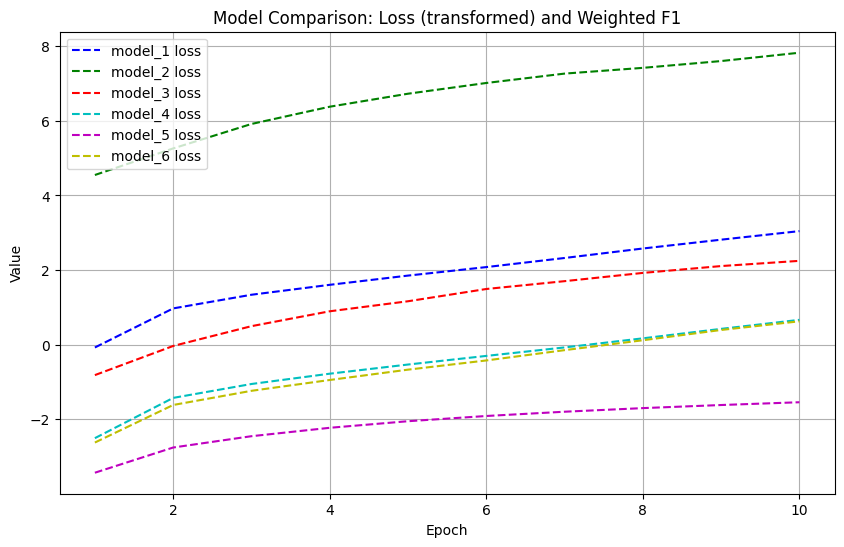

In [47]:
# 1) Plot Loss
epochs = np.arange(1, 11)
plt.figure(figsize=(10,6))
for i, model in enumerate(models):
    loss = np.array(model_metrics[model]['loss'])
    # Log-transform to shrink large differences
    loss_transformed = np.log(loss + 1e-8)  # add small epsilon to avoid log(0)
    plt.plot(epochs, -loss_transformed, color=colors[i], linestyle='--', label=f"{model} loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Model Comparison: Loss (transformed) and Weighted F1")
plt.legend()
plt.grid(True)
plt.show()

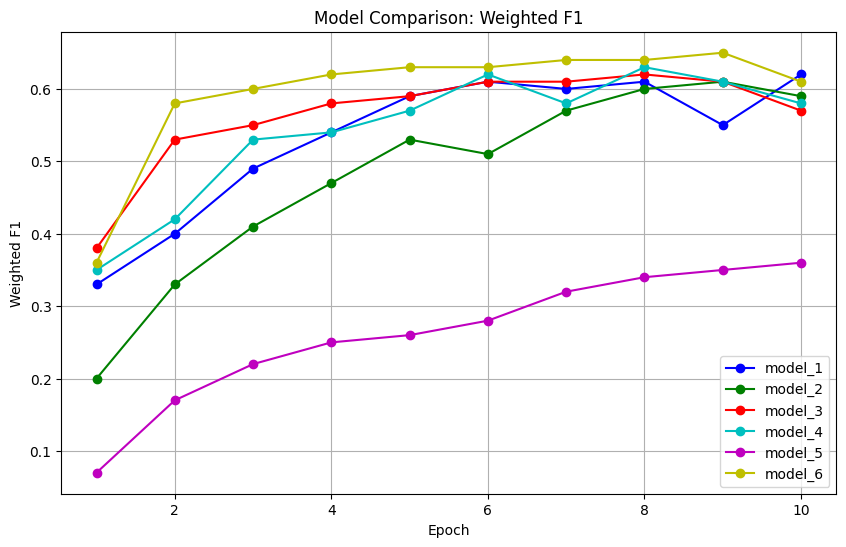

In [48]:
# Plot weighted F1
plt.figure(figsize=(10,6))
for i, model in enumerate(models):
    weighted_f1 = model_metrics[model]["weighted_f1"]
    plt.plot(epochs, weighted_f1, marker='o', color=colors[i], label=model)

plt.xlabel("Epoch")
plt.ylabel("Weighted F1")
plt.title("Model Comparison: Weighted F1")
plt.legend()
plt.grid(True)
plt.show()

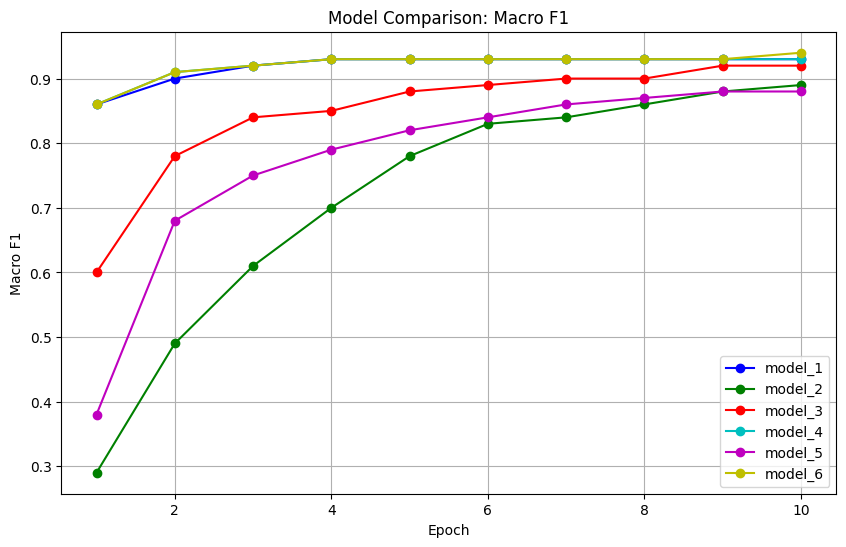

In [51]:
# Plot macro F1
plt.figure(figsize=(10,6))
for i, model in enumerate(models):
    macro_f1 = model_metrics[model]["macro_f1"]
    plt.plot(epochs, macro_f1, marker='o', color=colors[i], label=model)
plt.xlabel("Epoch")
plt.ylabel("Macro F1")
plt.title("Model Comparison: Macro F1")
plt.legend()
plt.grid(True)
plt.show()